In [18]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_milvus import Milvus
from typing import List, Optional
from langchain.schema import Document
from pydantic import BaseModel, Field
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from pprint import pprint
from langchain.retrievers.multi_query import MultiQueryRetriever
from typing_extensions import TypedDict
from langchain_core.output_parsers import BaseOutputParser
import logging
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

from pydantic import BaseModel, Field
import json 
import uuid

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

from dotenv import load_dotenv

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [19]:
load_dotenv()

True

In [20]:
MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"
MILVUS_COLLECTION_NAME = "manuals"

In [26]:
milvus_uri = f"http://{MILVUS_HOST}:{MILVUS_PORT}"
connection_args = {"uri": milvus_uri}

In [27]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [36]:
vectorstore = Milvus(
    collection_name="manuals",
    embedding_function=embeddings,
    connection_args=connection_args,
    auto_id=True,
    consistency_level="Strong",
    search_params={"metric_type": "L2", "params": {"nprobe": 10}}
)

In [29]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

In [37]:
# Response prompt 
response_prompt_template = """Você é um especialista em manuais automotivos. Vou lhe fazer uma pergunta. Sua resposta deve ser abrangente e não contradizer o contexto a seguir, caso ele seja relevante; caso contrário, ignore-o se não for pertinente.

# {normal_context}
# {step_back_context}

# Consulta Original: {question}
# Resposta:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

In [38]:
# Few Shot Examples
examples = [
    {
        "input": "Como ajusto a altura dos faróis quando o veículo está carregado?",
        "output": "procedimento de regulagem de altura dos faróis",
    },
    {
        "input": "Qual é o torque recomendado para apertar as porcas da roda após trocar um pneu?",
        "output": "especificação de torque das porcas de roda",
    },
    {
        "input": "Como posso verificar o nível de óleo do motor?",
        "output": "verificação do nível de óleo do motor",
    },
]

# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Você é um especialista em manuais automotivos. Sua tarefa é dar um passo atrás e parafrasear a pergunta, transformando-a em uma versão mais genérica e fácil de responder. Aqui estão alguns exemplos:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question¸
        ("user", "{question}"),
    ]
)

generate_query_step_back = prompt | llm | StrOutputParser()

In [43]:
class State(TypedDict):
    question: str
    brand: Optional[str]
    model: Optional[str]
    year: Optional[int]
    normal_context_docs: Optional[List[Document]]
    step_back_context_docs: Optional[List[Document]]
    generated_step_back_query: Optional[str]
    answer: str

In [45]:
def retrieve(state: State): # Renomeado para clareza
    """
    Retrieves both normal and step-back contexts and updates the state.
    
    Args:
        state (State): The current state containing the user's question and optional filters.
        
    Returns:
        dict: A dictionary with keys "normal_context_docs" and "step_back_context_docs".
    """
    question = state['question']
    # 1. Construir a EXPRESSÃO DE FILTRO (o formato que funciona para você)
    brand = state.get("brand")
    model = state.get("model")
    year = state.get("year")

    filter_conditions = []
    if brand:
        filter_conditions.append(f'brand == "{brand}"')
    if model:
        filter_conditions.append(f'model == "{model}"')
    if year:
        filter_conditions.append(f'year == "{str(year)}"')

    filter_expr = " and ".join(filter_conditions) if filter_conditions else None

    # Prepara os argumentos de busca com a expressão e o k desejado
    search_kwargs = {"k": 10}
    if filter_expr:
        search_kwargs['expr'] = filter_expr
        print(f"Filtro que será embutido no retriever: '{filter_expr}'")
    else:
        print("Nenhum filtro dinâmico a ser aplicado.")

    # 2. Criar um retriever dinâmico com o filtro "embutido"
    # Este retriever só existe para esta execução e tem o filtro correto.
    filtered_retriever = vectorstore.as_retriever(
        search_kwargs=search_kwargs
    )

    # 3. Gerar a consulta step-back (sua lógica está perfeita)
    print("Gerando consulta step-back...")
    generated_step_back_query = generate_query_step_back.invoke({"question": question})
    print(f"Consulta step-back gerada: '{generated_step_back_query}'")

    # 4. Recuperar AMBOS os contextos usando o retriever JÁ FILTRADO
    print(f"Buscando 'normal_context' para: '{question}'")
    normal_docs = filtered_retriever.invoke(question)
    print(f"Documentos 'normal_context' recuperados: {len(normal_docs)}")

    print(f"Buscando 'step_back_context' para: '{generated_step_back_query}'")
    step_back_docs = filtered_retriever.invoke(generated_step_back_query)
    print(f"Documentos 'step_back_context' recuperados: {len(step_back_docs)}")

    return {
        "normal_context_docs": normal_docs,
        "step_back_context_docs": step_back_docs,
        "generated_step_back_query": generated_step_back_query
    }

def generate(state: State): 
    """
    Generates the final answer using both normal and step-back contexts from the state.
    
    Args:
        state (State): The current state containing the question and the retrieved context documents.
    
    Returns:
        dict: A dictionary with the key "answer" containing the final answer from the LLM.
    
    Raises:
        ValueError: If the response format from the LLM is unexpected.
    """
    print("Iniciando a geração da resposta final.")
    question = state['question']
    
    # Extrai o conteúdo textual dos documentos dos campos corretos do State
    normal_docs_content = "\n\n".join(doc.page_content for doc in state.get("normal_context_docs", []))
    step_back_docs_content = "\n\n".join(doc.page_content for doc in state.get("step_back_context_docs", []))

    # response_prompt espera "question", "normal_context", "step_back_context"
    messages = response_prompt.invoke({
        "question": question,
        "normal_context": normal_docs_content,
        "step_back_context": step_back_docs_content
    })
    
    response = llm.invoke(messages)

    final_answer = ""
    if hasattr(response, "content"):
        final_answer = response.content
    elif isinstance(response, str):
        final_answer = response
    else:
        raise ValueError("Formato de resposta do LLM inesperado.")
    
    print(f"Resposta final gerada: '{final_answer}'")
    return {"answer": final_answer}

In [46]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

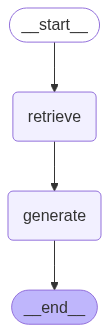

In [47]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def save_response_json(resposta_final: dict, filename: str = "resultados_rag_vw.json", modelo_rag: str = "rag"):
    """
    Gets the final response from the RAG process and saves it to a JSON file.
    
    Args:
        resposta_final (dict): The final response dictionary containing the question, context, and answer.
        filename (str): The name of the JSON file to save the results. Defaults to 'resultados_rag.json'.
        
    Returns:
        None: The function saves the response to a JSON file and does not return anything.
    """
    # Combina os dois contextos em uma string única para ter o contexto completo usado na geração
    contexto_completo = (
        "--- CONTEXTO DA PERGUNTA NORMAL ---\n"
        + "\n\n".join(doc.page_content for doc in resposta_final.get("normal_context_docs", []))
        + "\n\n--- CONTEXTO DA PERGUNTA STEP-BACK ---\n"
        + "\n\n".join(doc.page_content for doc in resposta_final.get("step_back_context_docs", []))
    )
    
    resultado = {
        "id_pergunta": f"P_{str(uuid.uuid4())[:8]}",
        "pergunta_usuario": resposta_final["question"],
        "pergunta_step_back_gerada": resposta_final.get("generated_step_back_query", "N/A"),
        "contexto_recuperado": contexto_completo,
        "resposta_gerada": resposta_final["answer"],
        "modelo_rag": modelo_rag,
        "metadados": {
            "marca": resposta_final.get("brand"),
            "modelo": resposta_final.get("model"),
            "ano": resposta_final.get("year")
        }
    }

    try:
        with open(filename, 'r', encoding='utf-8') as f:
            lista_resultados = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        lista_resultados = []
        
    lista_resultados.append(resultado)
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(lista_resultados, f, ensure_ascii=False, indent=4)
        
    print(f"✅ Resposta salva com sucesso em '{filename}'")

## **Questions** 

### **Volkswagen**

In [49]:
question = [
    "Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?", # 1
    "Como eu conecto meu celular Android no carro para usar os aplicativos na tela?", # 2
    "Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?", # 3
    "A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?", # 4
    "Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?", # 5
    "Como eu ajusto a hora no painel do carro?", # 6
    "Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?", # 7
    "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?", # 8
    "Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?", # 9
    "Quando é a próxima revisão do carro? É por tempo ou por quilometragem?" # 10
]

### 1 - Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?

In [50]:
response = graph.invoke({"question": question[0], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
             '(parece um motorzinho). O que pode ser e o que eu devo fazer?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Acendeu uma luz amarela no painel com um desenho de motor (parece um '
 'motorzinho). O que pode ser e o que eu devo fazer?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
             '(parece um motorzinho). O que pode ser e o que eu devo fazer?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
           

In [51]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_vw.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
A luz amarela que se acendeu no painel do seu veículo, representando um motor (geralmente conhecida como "luz de verificação do motor" ou "check engine"), indica que há uma falha ou anomalia no sistema de controle do motor. Essa luz pode acender por diversos motivos, que vão desde problemas menores, como uma tampa de combustível mal fechada, até questões mais sérias, como falhas no sistema de emissões ou no próprio motor.

### O que fazer:

1. **Verifique o Manual do Proprietário**: Consulte o manual do seu veículo para entender o significado específico da luz de advertência, pois pode haver variações dependendo do modelo e ano do carro.

2. **Reduza a Velocidade**: Se a luz estiver acesa enquanto você dirige, é aconselhável diminuir a velocidade e conduzir com cautela até um local seguro.

3. **Verifique o Nível de Combustível**: Certifique-se de que a tampa do combustível está bem fechada. Uma tampa solta pode causar a ativação da luz.

4. **Monitoramento do 

### 2 - Como eu conecto meu celular Android no carro para usar os aplicativos na tela?

In [52]:
response = graph.invoke({"question": question[1], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
Filtro que será embutido no retriever: 'brand == "Volkswagen" and model == "Polo" and 

In [53]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_vw.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Para conectar seu celular Android ao carro e utilizar os aplicativos na tela do sistema Infotainment, siga os passos abaixo:

### 1. Verifique os Requisitos
Antes de tudo, certifique-se de que seu telefone móvel atende aos seguintes requisitos:
- O telefone precisa suportar o Android Auto™.
- Você deve ter um cabo USB original do fabricante do telefone para a conexão.
- Dependendo do modelo do seu telefone, pode ser necessário instalar um aplicativo específico para o Android Auto™.

### 2. Conexão Inicial
- **Conecte o Telefone**: Use o cabo USB para conectar seu telefone ao rádio do carro. Se o seu carro e telefone suportarem, você também pode optar por uma conexão wireless via Wi-Fi.
- **Siga as Instruções**: Quando conectar pela primeira vez, siga as instruções que aparecerão tanto no display do rádio quanto no display do telefone.

### 3. Acesso ao Android Auto™
- **Pressione o Botão APP**: No rádio do carro, pressione o botão designado para acessar as funç

### 3 - Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?

In [54]:
response = graph.invoke({"question": question[2], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
Filt

In [55]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_vw.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
A calibragem correta dos pneus é fundamental para garantir a segurança, o desempenho e a eficiência do seu veículo. Para encontrar a pressão adequada dos pneus, você deve consultar a etiqueta adesiva que normalmente está localizada na parte interna da portinhola do tanque de combustível ou na porta do motorista. Essa etiqueta fornece informações específicas sobre a pressão recomendada para os pneus dianteiros e traseiros, tanto para condições de carregamento normal quanto para carregamento total.

### Pressão dos Pneus
1. **Verificação Regular**: É recomendado verificar a pressão dos pneus pelo menos a cada 15 dias e antes de viagens longas. A verificação deve ser feita com os pneus frios, ou seja, após o veículo ter rodado não mais que alguns quilômetros e em baixa velocidade nas últimas 3 horas.
   
2. **Valores de Pressão**: A pressão indicada na etiqueta é válida para pneus frios. Pneus quentes podem ter uma pressão mais alta, portanto, nunca ajuste a press

### 4 - A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?

In [56]:
response = graph.invoke({"question": question[3], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': 

In [57]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_vw.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
A luz de advertência do freio acesa em vermelho, acompanhada de um alerta sonoro, indica uma situação crítica que requer atenção imediata. De acordo com o manual, essa luz pode sinalizar um nível muito baixo do fluido de freio ou uma avaria no sistema de freios. É importante ressaltar que, ao ver essa luz acesa, a recomendação é **não prosseguir** com a condução do veículo.

Aqui estão os passos que você deve seguir:

1. **Parar o Veículo**: Assim que for seguro, pare o veículo em um local seguro, longe da pista de rodagem, para evitar riscos a você e aos outros motoristas.

2. **Verificar a Situação**: Após estacionar, verifique se há algum vazamento de fluido de freio ou se há outros sinais visíveis de problemas no sistema de freios.

3. **Consultar um Profissional**: Se a luz continuar acesa após a parada e a verificação inicial, é essencial procurar assistência técnica especializada. Ignorar essa luz pode resultar em falhas graves no sistema de freios, colo

### 5 - Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?

In [58]:
response = graph.invoke({"question": question[4], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'year': '2025'}
[1:tasks] Starting 1 ta

In [59]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_vw.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
O sistema que você mencionou é conhecido como sistema Start-Stop. Ele é projetado para desligar automaticamente o motor do veículo quando este para, como em semáforos ou em situações de tráfego intenso, e reiniciá-lo quando o condutor está pronto para seguir em frente, geralmente ao soltar o pedal do freio ou pressionar o acelerador. O objetivo principal desse sistema é economizar combustível e reduzir as emissões de poluentes, contribuindo para uma condução mais eficiente.

### Como Funciona o Sistema Start-Stop

1. **Desligamento Automático**: Quando o veículo para e o pedal do freio é pressionado, o motor se desliga automaticamente. Isso ocorre em condições específicas, como:
   - O condutor está usando o cinto de segurança.
   - A porta do condutor está fechada.
   - A tampa do compartimento do motor está fechada.
   - O motor atingiu uma temperatura mínima.
   - A carga da bateria de 12 V é suficiente.
   - O veículo não está em um aclive ou declive acentu

### 6 - Como eu ajusto a hora no painel do carro?

In [60]:
response = graph.invoke({"question": question[5], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
Filtro que será embutido no retriever: 'brand == "Volkswagen" and model == "Polo" and year == "2025"'
Gerando consulta step-back...
Consulta step-back gerada: 'procedimento para ajustar a hora no painel do veículo'
Buscando 'normal_context' para: 'Como eu ajusto a hora no painel do

In [61]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_vw.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Para ajustar a hora no painel do carro, você pode seguir diferentes métodos, dependendo do tipo de painel que seu veículo possui. Aqui estão as instruções para os três tipos principais: rádio, instrumento combinado digital (Active Info Display) e instrumento combinado analógico.

### 1. Ajustar o horário através do sistema de rádio
- **Pressione o botão do rádio**.
- **Toque na superfície de função** para abrir o menu **Configurações do veículo**.
- **Selecione o item de menu** **Hora e data** para ajustar o horário.
- **OU**
- **Pressione o botão configurações**.
- **Toque na superfície de função** **Carro** para abrir o menu.
- **Selecione o item de menu** **Data e hora** para ajustar o horário.

### 2. Ajustar o horário através do instrumento combinado digital (Active Info Display)
- No menu **Dados de viagem**, selecione o indicador **Autonomia**.
- **Mantenha pressionado o botão OK** no volante multifunções durante cerca de cinco segundos. O menu de serviç

### 7 - Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?

In [62]:
response = graph.invoke({"question": question[6], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu '
 'faço a troca?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
Filtro que será embutido no retr

In [63]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_vw.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Se você furar um pneu, o macaco e as ferramentas necessárias para a troca de roda geralmente estão localizados no compartimento de bagagem do veículo. A localização exata pode variar de acordo com o modelo do carro, mas normalmente você encontrará o macaco e a chave de roda em um compartimento específico, muitas vezes sob o piso do porta-malas ou em um compartimento lateral.

### Passo a Passo para Trocar o Pneu:

1. **Preparação**:
   - Estacione o veículo em um local seguro, longe do fluxo de trânsito.
   - Acione o freio de estacionamento e desligue o motor.
   - Se o veículo tiver transmissão automática, coloque a alavanca seletora na posição "P". Se for manual, engate uma marcha.

2. **Ferramentas Necessárias**:
   - Macaco
   - Chave de roda
   - Gancho extrator (se disponível)
   - Triângulo de segurança e luzes de advertência (para segurança)

3. **Soltar os Parafusos**:
   - Utilize a chave de roda para soltar os parafusos da roda furada. Enquanto o ve

### 8 - O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?

In [64]:
response = graph.invoke({"question": question[7], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a difer

In [65]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_vw.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Os modos de condução 'Eco' e 'Sport' oferecem experiências de direção distintas, adaptando o desempenho do veículo às preferências do condutor e às condições de condução.

### Modo Eco
- **Objetivo**: O perfil de condução Eco é projetado para maximizar a eficiência de combustível e promover uma condução econômica. 
- **Características**:
  - O veículo opera em um estado de baixo consumo, o que significa que os sistemas do motor e do chassi são ajustados para reduzir o consumo de combustível.
  - A posição de marcha é automaticamente comutada para a função de roda-livre, permitindo que o veículo desacelere sem resistência do motor, o que contribui para a economia de combustível.
- **Quando usar**: Ideal para condução em áreas urbanas ou em longas distâncias, onde a eficiência de combustível é uma prioridade.

### Modo Sport
- **Objetivo**: O perfil de condução Sport é voltado para uma experiência de condução mais dinâmica e esportiva.
- **Características**:
  - 

### 9 - Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?

In [66]:
response = graph.invoke({"question": question[8], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no man

In [67]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_vw.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Sim, o seu Volkswagen Polo pode puxar um reboque pequeno, desde que esteja equipado com um dispositivo de reboque adequado e que respeite as especificações de carga de reboque e carga de apoio indicadas no manual do veículo. Aqui estão algumas recomendações e considerações importantes a serem seguidas:

### 1. **Verifique a Capacidade de Tração**
Antes de tudo, consulte os documentos do seu veículo para verificar a capacidade máxima de tração e a carga de apoio admissível. Essas informações são cruciais para garantir que o reboque não exceda os limites do seu Polo.

### 2. **Instalação do Dispositivo de Reboque**
Se o seu Polo ainda não possui um dispositivo de reboque instalado, é fundamental que a instalação seja feita de acordo com as instruções do fabricante do engate. Utilize os pontos de fixação indicados no manual e assegure-se de que o dispositivo esteja fixado com segurança no chassi do veículo.

### 3. **Carregamento do Reboque**
Ao carregar o reboque

### 10 - Quando é a próxima revisão do carro? É por tempo ou por quilometragem?

In [68]:
response = graph.invoke({"question": question[9], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
Filtro que será embutido no retriever: 'brand == "Volkswagen" and model == "Polo" and year == "2025"'
Gerando consulta

In [69]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_vw.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
A próxima revisão do seu carro deve ser realizada com base em um dos dois critérios: quilometragem ou tempo, prevalecendo o que ocorrer primeiro. 

1. **Condições Normais**: Se o uso do veículo não se enquadra em condições adversas, a manutenção deve ser feita a cada 10.000 km ou 12 meses, o que ocorrer primeiro.

2. **Condições Adversas**: Se o veículo for utilizado em condições severas, como tráfego intenso, trajetos curtos, ou em estradas ruins, a manutenção deve ser realizada a cada 10.000 km ou 6 meses, prevalecendo novamente o que ocorrer primeiro.

É importante seguir rigorosamente esses prazos de verificação e substituição para garantir a segurança e a integridade do veículo, além de manter a garantia. Caso tenha dúvidas sobre a quilometragem ou o tempo até a próxima revisão, você pode verificar o aviso de serviço que aparece ao ligar a ignição do veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_stepback_vw.json'


### **Fiat**

In [70]:
question = [
    "Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?", # 1
    "A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?", # 2
    "Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?", # 3
    "A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?", # 4
    "Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?", # 5
    "As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?", # 6
    "Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?", # 7
    "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?", # 8
    "Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?", # 9
    "Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?" # 10
]

### 1- Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?

In [71]:
response = graph.invoke({"question": question[0], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as '
 'ferramentas, e quais os passos principais para trocar o pneu em segurança?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',

In [72]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_fiat.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Para trocar um pneu furado em segurança, siga os passos abaixo, que incluem a localização do estepe, do macaco e das ferramentas necessárias:

### Localização das Ferramentas
- **Macaco e Ferramentas**: Estão localizados no porta-ferramentas B, que fica sob a roda sobressalente.
- **Triângulo de Segurança**: Encontra-se no porta-malas, próximo ao sistema de travamento da tampa.

### Passos para Trocar o Pneu em Segurança

1. **Parar o Veículo**:
   - Estacione o veículo em um local seguro, longe da borda da pista, em uma superfície plana e firme.
   - Ligue as luzes de emergência e acione o freio de estacionamento.
   - Engate a primeira marcha ou a marcha a ré e desligue o motor.

2. **Preparar o Veículo**:
   - Se estiver em uma estrada inclinada ou em terreno instável, calce as rodas do veículo na diagonal oposta à roda que será substituída.
   - Avise as pessoas ao redor que o veículo será levantado e peça que se afastem.

3. **Aliviar os Parafusos**:
   - 

### 2 - A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?

In [73]:
response = graph.invoke({"question": question[1], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A bateria parece ter descarregado e o carro não liga. Como posso fazer a '
 'partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar '
 'nada?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fi

In [74]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_fiat.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Para realizar a partida do motor com uma bateria auxiliar (chupeta) de outro veículo de forma segura e eficaz, siga os passos abaixo, garantindo que você não danifique nenhum componente do seu veículo ou coloque em risco a segurança de pessoas ao redor.

### Preparação
1. **Verifique a Bateria**: Antes de tudo, certifique-se de que a bateria do veículo auxiliar está em boas condições e totalmente carregada.
2. **Posicione os Veículos**: Estacione o veículo auxiliar próximo ao seu carro, de modo que os cabos de ligação alcancem ambas as baterias, mas evite que os veículos se toquem.
3. **Desligue os Veículos**: Certifique-se de que ambos os veículos estão desligados e que todos os acessórios elétricos (como faróis, rádio, etc.) estão desligados.

### Ligação dos Cabos
1. **Conecte o Cabo Positivo (+)**:
   - Pegue um cabo vermelho (positivo) e conecte uma extremidade ao terminal positivo (+) da bateria descarregada do seu veículo.
   - Conecte a outra extremidad

### 3 - Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?

In [75]:
response = graph.invoke({"question": question[2], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
Filtro que será embutido no retriever: '

In [76]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_fiat.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Para determinar a pressão correta dos pneus do seu carro, você deve consultar o manual do proprietário, especificamente o capítulo intitulado "Dados Técnicos". Neste capítulo, você encontrará informações detalhadas sobre a pressão recomendada para os pneus, tanto para os pneus dianteiros quanto para os traseiros, além do pneu sobressalente.

Além disso, a pressão dos pneus geralmente está indicada em um adesivo localizado na parte interna da porta do motorista ou na tampa do tanque de combustível. Este adesivo fornece os valores de pressão recomendados pelo fabricante, que devem ser respeitados para garantir a segurança e o desempenho do veículo.

É importante lembrar que a calibragem dos pneus deve ser feita com os pneus frios, ou seja, antes de dirigir ou após o veículo ter estado parado por algumas horas. Isso porque a pressão dos pneus aumenta com o calor gerado durante a condução, e medir a pressão enquanto os pneus estão quentes pode resultar em leituras 

### 4 - A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?

In [77]:
response = graph.invoke({"question": question[3], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
Filtro que será embutido no retriever: 'brand == "Fiat" and model == "Argo" and 

In [78]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_fiat.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Se a luz de temperatura do motor acendeu e você está notando vapor saindo do capô, é crucial agir com cautela para evitar danos ao veículo e garantir sua segurança. Aqui estão os passos que você deve seguir:

1. **Parar o Veículo Imediatamente**: Assim que perceber a luz de temperatura acesa e o vapor, pare o veículo em um local seguro e desligue o motor. Isso ajuda a evitar danos adicionais ao motor e ao sistema de arrefecimento.

2. **Não Abra o Capô Imediatamente**: Se houver vapor visível, não tente abrir o capô até que o radiador tenha esfriado. A saída de vapor ou líquido de arrefecimento quente pode causar queimaduras graves.

3. **Verifique o Nível do Líquido de Arrefecimento**: Após o motor ter esfriado, verifique o nível do líquido de arrefecimento no reservatório. Se o nível estiver abaixo da marca mínima (MIN), você precisará repor o líquido. 

4. **Reabastecimento do Líquido de Arrefecimento**: Se for necessário adicionar líquido, faça isso com cui

### 5 - Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?

In [79]:
response = graph.invoke({"question": question[4], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Passei num buraco e meu carro parou de funcionar, não liga mais. Será que '
 'ativou alguma trava de segurança do motor? O que eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu car

In [80]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_fiat.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Se o seu carro parou de funcionar após passar por um buraco, é possível que tenha ocorrido uma avaria em algum componente do sistema elétrico ou mecânico, ou até mesmo uma ativação de um sistema de segurança. Aqui estão algumas etapas que você pode seguir para diagnosticar e, se possível, resolver o problema:

1. **Verifique a Luz do Painel**: Ao girar a chave para a posição MAR, observe se a luz-espia acende. Se a luz não acender ou se acender de forma intermitente, isso pode indicar um problema no sistema elétrico ou no comutador de ignição. Nesse caso, é recomendável entrar em contato com a Rede Assistencial Fiat.

2. **Checagem do Freio de Estacionamento**: Certifique-se de que o freio de estacionamento está acionado. Se o carro estiver em uma posição que não permita a partida, isso pode ser um fator.

3. **Sistema de Bloqueio do Motor**: Se a luz-espia acender e o código da chave não for reconhecido, isso pode indicar que o sistema de proteção e bloqueio d

### 6 - As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?

In [81]:
response = graph.invoke({"question": question[5], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luz

In [82]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_fiat.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Sim, é perigoso continuar dirigindo com as luzes do ABS e do freio acesas simultaneamente no painel do seu Fiat Argo. O acendimento dessas luzes indica uma avaria no sistema de freios, especificamente no sistema ABS (Antilock Braking System) e possivelmente no sistema EBD (Electronic Brakeforce Distribution). 

Quando a luz do ABS acende, isso significa que o sistema está ineficiente, o que pode comprometer a eficácia da frenagem, especialmente em situações de emergência. Embora o sistema de freios ainda funcione, você não terá os benefícios do ABS, que ajuda a evitar o travamento das rodas durante a frenagem brusca, aumentando a estabilidade e o controle do veículo.

Além disso, o acendimento da luz de freio (vermelha com um ponto de exclamação) pode indicar que há um problema mais sério, como baixa pressão no fluido de freio ou desgaste nas pastilhas de freio. Isso pode resultar em uma frenagem ineficaz, aumentando o risco de acidentes.

Diante dessa situação

### 7 - Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?

In [83]:
response = graph.invoke({"question": question[6], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
Filtro que será embutido no retriever: 'brand == "Fiat" and 

In [84]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_fiat.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Se você esquecer a chave eletrônica dentro do carro e tentar trancar as portas, o sistema de segurança do veículo não permitirá que as portas sejam trancadas. Isso ocorre porque, ao detectar a presença da chave eletrônica no interior do veículo, o sistema impede o travamento das portas para evitar que a chave fique trancada dentro do carro.

Caso você tente trancar as portas usando o botão de travamento, o veículo não responderá a esse comando. Para reativar o funcionamento normal do sistema, será necessário pressionar o botão no telecomando da chave eletrônica. Assim, o sistema reconhecerá que a chave está fora do veículo e permitirá o travamento das portas.

Além disso, se você tentar fechar o porta-malas enquanto a chave estiver dentro dele, o sistema também não permitirá o fechamento, a menos que uma outra chave eletrônica reconhecida esteja presente nas proximidades do veículo. Se você tentar fechar o porta-malas e a chave estiver dentro, o sistema abrirá 

### 8 - Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?

In [85]:
response = graph.invoke({"question": question[7], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 

In [86]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_fiat.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
Sim, o aviso de 'HCSS' (Sistema de Aquecimento de Combustível) e a luz-espia que se assemelha a uma 'mola' são comportamentos normais do sistema, especialmente em condições de temperatura baixa, como quando a temperatura está abaixo de cerca de 30°C. O HCSS é projetado para facilitar a partida do motor em climas frios, especialmente quando o veículo está abastecido com etanol ou uma mistura de etanol e gasolina.

Quando você abre a porta do lado do motorista, o sistema de preaquecimento de combustível é ativado, e a luz-espia acende no quadro de instrumentos, acompanhada de uma mensagem específica. Isso indica que o sistema está funcionando e que o combustível está sendo aquecido até atingir a temperatura ideal para a partida. É importante aguardar até que a luz-espia se apague antes de tentar dar a partida no veículo. Isso garante que o motor tenha as melhores condições para iniciar.

Se a luz-espia piscar de forma intermitente, isso pode indicar que o sistema

### 9 - Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?

In [87]:
response = graph.invoke({"question": question[8], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
Filtro que será embutido no retriever: 'brand == "Fiat" and model == "Argo" and year == "2023"'
Gerando consulta step-

In [88]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_fiat.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
O tanque de combustível do veículo possui uma capacidade total de 47 litros, incluindo a reserva. A reserva de combustível, que é a quantidade que resta no tanque quando a luz de alerta acende, varia entre 5,50 a 7,50 litros. Portanto, ao considerar a capacidade total do tanque, você pode contar com até 47 litros de combustível, sendo que a parte da reserva é uma quantidade que deve ser monitorada para evitar ficar sem combustível.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_stepback_fiat.json'


### 10 - Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?

In [89]:
response = graph.invoke({"question": question[9], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando '
 'troco o filtro junto?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
Filtro que será embutido no 

In [90]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_stepback_fiat.json", modelo_rag="rag_stepback")


--- Resposta gerada ---
A capacidade de óleo do motor para o Argo com motor 1.0 Flex, ao trocar o filtro de óleo junto, é de 5,50 a 7,50 litros. É importante seguir as recomendações do fabricante e utilizar uma peça genuína para o filtro de óleo. Além disso, sempre consulte o "Plano de Manutenção Programada" para garantir que os intervalos de troca de óleo e filtro sejam respeitados, de acordo com o tipo de utilização do veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_stepback_fiat.json'
